<a href="https://colab.research.google.com/github/MarcosRigal/CNC/blob/main/P3/P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3

In [1]:
!pip install git+https://github.com/globality-corp/sklearn-hierarchical-classification.git

  Cloning https://github.com/globality-corp/sklearn-hierarchical-classification.git to /tmp/pip-req-build-6nu7wmzq
  Running command git clone --filter=blob:none --quiet https://github.com/globality-corp/sklearn-hierarchical-classification.git /tmp/pip-req-build-6nu7wmzq
  Resolved https://github.com/globality-corp/sklearn-hierarchical-classification.git to commit 1de19f782d992a82dace895f9c24a0fc074baeeb
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn-hierarchical-classification: filename=sklearn_hierarchical_classification-1.3.2-py3-none-any.whl size=22883 sha256=72acec523ffa42d7195cff1eab815a82969e6a5bf9341123b6c284d49b898a3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cquuyww4/wheels/ba/80/9f/fed09501afa17cb8e77b237b97de493a339b405e98025cc8ac
Successfully built sklearn-hierarchical-classification


In [2]:
!git clone https://github.com/geantrindade/TEsHierarchicalDatasets.git

Cloning into 'TEsHierarchicalDatasets'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (60/60), 44.67 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (46/46), done.


Starting hierarchical classification experiments...
Loading all available datasets...
Loading MIPS Kmers dataset...
Loading MIPS Pseudo dataset...
Loading MIPS Kmers Pseudo dataset...
Loading Repbase Kmers dataset...

Processing MIPS Kmers dataset...


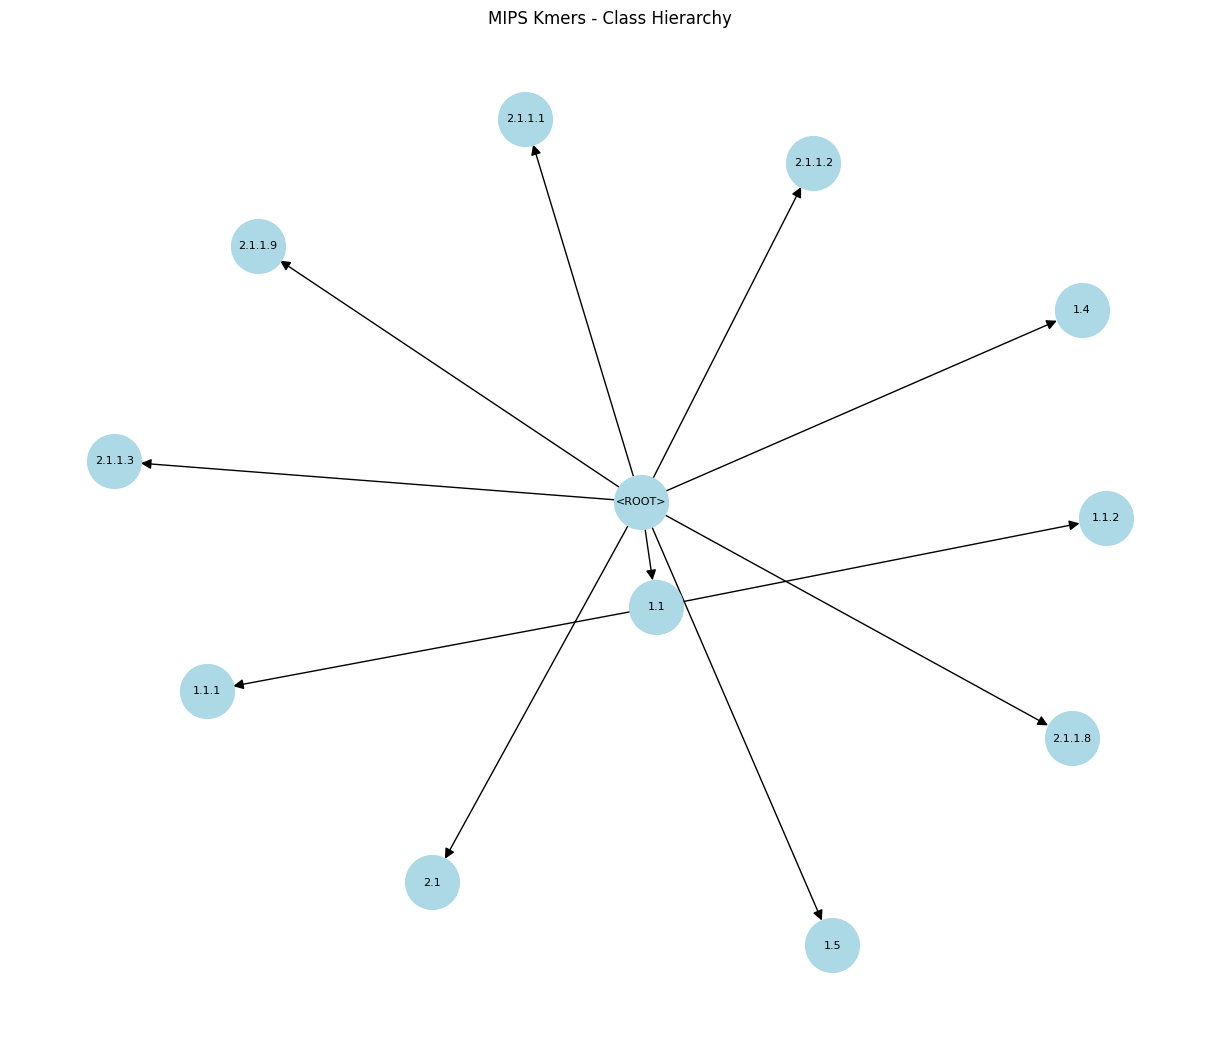

Training Hierarchical SVM on MIPS Kmers...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Define utility functions for data preprocessing and evaluation

def preprocess_dataset(X, y, test_size=0.25, random_state=42):
    """Preprocess dataset: split, impute missing values, standardize."""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Feature selection (select top k features based on ANOVA F-value)
    selector = SelectKBest(f_classif, k=min(100, X_train.shape[1]))
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    return X_train, X_test, y_train, y_test

def build_class_hierarchy(labels):
    """Build a simple hierarchical graph based on label structure."""
    G = nx.DiGraph()

    # Add root node
    G.add_node(ROOT)

    # Extract unique labels and sort them (assumption: labels follow a hierarchical pattern with dot notation)
    unique_labels = sorted(set(labels))

    # Add all nodes and edges
    for label in unique_labels:
        parts = label.split('.')

        # Add node for the complete label
        G.add_node(label)

        # Connect to parent node or root
        if len(parts) > 1:
            parent = '.'.join(parts[:-1])
            if parent in unique_labels:
                G.add_edge(parent, label)
            else:
                G.add_edge(ROOT, label)
        else:
            G.add_edge(ROOT, label)

    return G

def custom_hierarchical_fbeta(y_true, y_pred, class_hierarchy, beta=1.0):
    """Custom hierarchical F-beta score implementation."""
    # Calculate precision and recall
    precision = custom_hierarchical_precision(y_true, y_pred, class_hierarchy)
    recall = custom_hierarchical_recall(y_true, y_pred, class_hierarchy)

    # Calculate F-beta
    if precision + recall == 0:
        return 0.0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

def custom_hierarchical_precision(y_true, y_pred, class_hierarchy):
    """Custom hierarchical precision score implementation."""
    total_correct = 0
    total_predicted = 0

    for true, pred in zip(y_true, y_pred):
        # Get all ancestors of the predicted class
        pred_ancestors = set(nx.ancestors(class_hierarchy, pred))
        pred_ancestors.add(pred)  # Include the class itself

        # Get all ancestors of the true class
        true_ancestors = set(nx.ancestors(class_hierarchy, true))
        true_ancestors.add(true)  # Include the class itself

        # Remove ROOT from both sets if present
        if ROOT in pred_ancestors:
            pred_ancestors.remove(ROOT)
        if ROOT in true_ancestors:
            true_ancestors.remove(ROOT)

        # Calculate intersection
        correct = len(pred_ancestors.intersection(true_ancestors))

        total_correct += correct
        total_predicted += len(pred_ancestors)

    if total_predicted == 0:
        return 0.0
    return total_correct / total_predicted

def custom_hierarchical_recall(y_true, y_pred, class_hierarchy):
    """Custom hierarchical recall score implementation."""
    total_correct = 0
    total_actual = 0

    for true, pred in zip(y_true, y_pred):
        # Get all ancestors of the predicted class
        pred_ancestors = set(nx.ancestors(class_hierarchy, pred))
        pred_ancestors.add(pred)  # Include the class itself

        # Get all ancestors of the true class
        true_ancestors = set(nx.ancestors(class_hierarchy, true))
        true_ancestors.add(true)  # Include the class itself

        # Remove ROOT from both sets if present
        if ROOT in pred_ancestors:
            pred_ancestors.remove(ROOT)
        if ROOT in true_ancestors:
            true_ancestors.remove(ROOT)

        # Calculate intersection
        correct = len(pred_ancestors.intersection(true_ancestors))

        total_correct += correct
        total_actual += len(true_ancestors)

    if total_actual == 0:
        return 0.0
    return total_correct / total_actual

def evaluate_classifier(clf, X_test, y_test, classifier_name, dataset_name):
    """Evaluate a hierarchical classifier and return metrics using custom functions."""
    y_pred = clf.predict(X_test)

    # Calculate standard accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate hierarchical metrics using custom functions
    h_precision = custom_hierarchical_precision(y_test, y_pred, clf.graph_)
    h_recall = custom_hierarchical_recall(y_test, y_pred, clf.graph_)
    h_f1 = custom_hierarchical_fbeta(y_test, y_pred, clf.graph_, beta=1.0)

    print(f"{classifier_name} on {dataset_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Hierarchical F1: {h_f1:.4f}")
    print(f"  Hierarchical Precision: {h_precision:.4f}")
    print(f"  Hierarchical Recall: {h_recall:.4f}")

    return {
        'accuracy': accuracy,
        'h_f1': h_f1,
        'h_precision': h_precision,
        'h_recall': h_recall
    }

def visualize_hierarchy(graph, title="Class Hierarchy"):
    """Visualize the class hierarchy as a graph."""
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue',
            node_size=1500, arrowsize=15, font_size=8)
    plt.title(title)
    plt.show()

# Step 2: Load and prepare the datasets

def load_datasets():
    """Load all available datasets from CSV files."""
    print("Loading all available datasets...")

    datasets = {}

    # MIPS Kmers
    print("Loading MIPS Kmers dataset...")
    df_mips_kmers = pd.read_csv('/content/TEsHierarchicalDatasets/csv/mips_kmers.csv')
    # Check if 'classe' exists instead of 'Class'
    y_column = 'classe' if 'classe' in df_mips_kmers.columns else 'Class'
    X_mips_kmers = df_mips_kmers.drop([y_column], axis=1, errors='ignore').values
    y_mips_kmers = df_mips_kmers[y_column].values
    datasets["MIPS Kmers"] = (X_mips_kmers, y_mips_kmers)

    # MIPS Pseudo
    print("Loading MIPS Pseudo dataset...")
    df_mips_pseudo = pd.read_csv('/content/TEsHierarchicalDatasets/csv/mips_pseudo.csv')
    y_column = 'classe' if 'classe' in df_mips_pseudo.columns else 'Class'
    X_mips_pseudo = df_mips_pseudo.drop([y_column], axis=1, errors='ignore').values
    y_mips_pseudo = df_mips_pseudo[y_column].values
    datasets["MIPS Pseudo"] = (X_mips_pseudo, y_mips_pseudo)

    # MIPS Kmers Pseudo
    print("Loading MIPS Kmers Pseudo dataset...")
    df_mips_kmers_pseudo = pd.read_csv('/content/TEsHierarchicalDatasets/csv/mips_kmers_pseudo.csv')
    y_column = 'classe' if 'classe' in df_mips_kmers_pseudo.columns else 'Class'
    X_mips_kmers_pseudo = df_mips_kmers_pseudo.drop([y_column], axis=1, errors='ignore').values
    y_mips_kmers_pseudo = df_mips_kmers_pseudo[y_column].values
    datasets["MIPS Kmers Pseudo"] = (X_mips_kmers_pseudo, y_mips_kmers_pseudo)

    # Repbase Kmers
    print("Loading Repbase Kmers dataset...")
    df_repbase_kmers = pd.read_csv('/content/TEsHierarchicalDatasets/csv/repbase_kmers.csv')
    y_column = 'classe' if 'classe' in df_repbase_kmers.columns else 'Class'
    X_repbase_kmers = df_repbase_kmers.drop([y_column], axis=1, errors='ignore').values
    y_repbase_kmers = df_repbase_kmers[y_column].values
    datasets["Repbase Kmers"] = (X_repbase_kmers, y_repbase_kmers)

    return datasets

# Algorithm 1: Hierarchical classifier with SVM as base estimator
def train_evaluate_hsvm(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name):
    """Train and evaluate Hierarchical SVM classifier."""
    # Create hierarchical classifier
    clf = HierarchicalClassifier(
        base_estimator=SVC(kernel='linear', probability=True, C=1.0),
        class_hierarchy=class_hierarchy,
        algorithm='lcpn',  # Local Classifier Per Node
        prediction_depth='mlnp',  # Most Likely Node Path
    )

    # Train classifier
    print(f"Training Hierarchical SVM on {dataset_name}...")
    clf.fit(X_train, y_train)

    # Evaluate
    return evaluate_classifier(clf, X_test, y_test, "Hierarchical SVM", dataset_name)

# Algorithm 2: Hierarchical classifier with Random Forest as base estimator
def train_evaluate_hrf(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name):
    """Train and evaluate Hierarchical Random Forest classifier."""
    # Create hierarchical classifier
    clf = HierarchicalClassifier(
        base_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        class_hierarchy=class_hierarchy,
        algorithm='lcpn',  # Local Classifier Per Node
        prediction_depth='mlnp',  # Most Likely Node Path
    )

    # Train classifier
    print(f"Training Hierarchical Random Forest on {dataset_name}...")
    clf.fit(X_train, y_train)

    # Evaluate
    return evaluate_classifier(clf, X_test, y_test, "Hierarchical Random Forest", dataset_name)

# Step 4: Load datasets and run experiments
print("Starting hierarchical classification experiments...")

# Load all available datasets
all_datasets = load_datasets()

# Store results
results = {}

# Process each dataset
for dataset_name, (X, y) in all_datasets.items():
    print(f"\nProcessing {dataset_name} dataset...")

    # Preprocess dataset
    X_train, X_test, y_train, y_test = preprocess_dataset(X, y)

    # Build class hierarchy
    class_hierarchy = build_class_hierarchy(y_train)

    # Visualize hierarchy
    visualize_hierarchy(class_hierarchy, f"{dataset_name} - Class Hierarchy")

    # Train and evaluate algorithms
    hsvm_results = train_evaluate_hsvm(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name)
    hrf_results = train_evaluate_hrf(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name)

    # Store results
    results[dataset_name] = {
        "HSVM": hsvm_results,
        "HRF": hrf_results
    }

# Step 5: Visualize results

# Accuracy comparison
def plot_metric_comparison(results, metric='accuracy', title=None):
    """Create a bar chart comparing algorithm performance."""
    datasets = list(results.keys())
    hsvm_values = [results[dataset]["HSVM"][metric] for dataset in datasets]
    hrf_values = [results[dataset]["HRF"][metric] for dataset in datasets]

    x = np.arange(len(datasets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, hsvm_values, width, label='Hierarchical SVM')
    ax.bar(x + width/2, hrf_values, width, label='Hierarchical Random Forest')

    metric_name = metric.replace('h_', 'Hierarchical ').title()
    ax.set_ylabel(metric_name)
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'{metric_name} by Algorithm and Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha='right')
    ax.legend()

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Plot comparisons for different metrics
print("\nPlotting comparison charts...")
plot_metric_comparison(results, 'accuracy', 'Accuracy Comparison')
plot_metric_comparison(results, 'h_f1', 'Hierarchical F1 Score Comparison')
plot_metric_comparison(results, 'h_precision', 'Hierarchical Precision Comparison')
plot_metric_comparison(results, 'h_recall', 'Hierarchical Recall Comparison')

# Step 6: Generate summary of findings
print("\n=== SUMMARY OF FINDINGS ===")

# 1. Algorithm Performance Comparison
print("1. Algorithm Performance Comparison:")

# Average metrics across datasets
avg_hsvm_acc = np.mean([results[dataset]["HSVM"]["accuracy"] for dataset in results])
avg_hsvm_f1 = np.mean([results[dataset]["HSVM"]["h_f1"] for dataset in results])
avg_hrf_acc = np.mean([results[dataset]["HRF"]["accuracy"] for dataset in results])
avg_hrf_f1 = np.mean([results[dataset]["HRF"]["h_f1"] for dataset in results])

print("   - Hierarchical SVM:")
for dataset in results:
    print(f"     {dataset}: Accuracy={results[dataset]['HSVM']['accuracy']:.4f}, H-F1={results[dataset]['HSVM']['h_f1']:.4f}")
print(f"     Average accuracy: {avg_hsvm_acc:.4f}, Average H-F1: {avg_hsvm_f1:.4f}")

print("   - Hierarchical Random Forest:")
for dataset in results:
    print(f"     {dataset}: Accuracy={results[dataset]['HRF']['accuracy']:.4f}, H-F1={results[dataset]['HRF']['h_f1']:.4f}")
print(f"     Average accuracy: {avg_hrf_acc:.4f}, Average H-F1: {avg_hrf_f1:.4f}")

# 2. Dataset Difficulty Analysis
print("\n2. Dataset Difficulty Analysis:")
datasets = list(results.keys())
hsvm_accs = [results[dataset]["HSVM"]["accuracy"] for dataset in datasets]
hrf_accs = [results[dataset]["HRF"]["accuracy"] for dataset in datasets]
avg_accs = [(m + n)/2 for m, n in zip(hsvm_accs, hrf_accs)]

# Sort datasets by difficulty (lower accuracy = more difficult)
dataset_difficulty = list(zip(datasets, avg_accs))
dataset_difficulty.sort(key=lambda x: x[1])

for dataset, acc in dataset_difficulty:
    print(f"   - {dataset}: Average accuracy {acc:.4f}")

# 3. Hierarchical Metrics Analysis
print("\n3. Hierarchical Metrics Analysis:")
for dataset in results:
    hsvm_h_prec = results[dataset]["HSVM"]["h_precision"]
    hsvm_h_rec = results[dataset]["HSVM"]["h_recall"]
    hrf_h_prec = results[dataset]["HRF"]["h_precision"]
    hrf_h_rec = results[dataset]["HRF"]["h_recall"]

    print(f"   - {dataset}:")
    print(f"     HSVM: H-Precision={hsvm_h_prec:.4f}, H-Recall={hsvm_h_rec:.4f}")
    print(f"     HRF:  H-Precision={hrf_h_prec:.4f}, H-Recall={hrf_h_rec:.4f}")

# 4. Conclusions
print("\n4. Conclusions:")
if avg_hsvm_acc > avg_hrf_acc:
    print("   - Hierarchical SVM performed better overall in terms of accuracy,")
    print("     suggesting it's more suitable for these hierarchical classification tasks.")
elif avg_hsvm_acc < avg_hrf_acc:
    print("   - Hierarchical Random Forest performed better overall in terms of accuracy,")
    print("     suggesting it's more suitable for these hierarchical classification tasks.")
else:
    print("   - Both algorithms performed similarly overall in terms of accuracy,")
    print("     but showed different strengths on specific datasets.")

# Compare hierarchical metrics
if avg_hsvm_f1 > avg_hrf_f1:
    print("   - Hierarchical SVM achieved better hierarchical F1 scores,")
    print("     indicating it better captures the hierarchical structure of the classes.")
elif avg_hsvm_f1 < avg_hrf_f1:
    print("   - Hierarchical Random Forest achieved better hierarchical F1 scores,")
    print("     indicating it better captures the hierarchical structure of the classes.")
else:
    print("   - Both algorithms achieved similar hierarchical F1 scores.")

# Final recommendation
print("\n5. Recommendations:")
if avg_hsvm_acc > avg_hrf_acc and avg_hsvm_f1 > avg_hrf_f1:
    print("   - Hierarchical SVM is recommended for these datasets as it performs better")
    print("     on both flat accuracy and hierarchical metrics.")
elif avg_hrf_acc > avg_hsvm_acc and avg_hrf_f1 > avg_hsvm_f1:
    print("   - Hierarchical Random Forest is recommended for these datasets as it performs better")
    print("     on both flat accuracy and hierarchical metrics.")
else:
    # Look at which datasets each algorithm performs best on
    hsvm_best = [dataset for dataset, hsvm, hrf in
                 zip(datasets, hsvm_accs, hrf_accs) if hsvm > hrf]
    hrf_best = [dataset for dataset, hsvm, hrf in
               zip(datasets, hsvm_accs, hrf_accs) if hrf > hsvm]

    if hsvm_best:
        print(f"   - Hierarchical SVM is recommended for {', '.join(hsvm_best)} datasets.")
    if hrf_best:
        print(f"   - Hierarchical Random Forest is recommended for {', '.join(hrf_best)} datasets.")

    print("   - Algorithm selection should be based on the specific dataset characteristics,")
    print("     as neither algorithm consistently outperforms the other across all datasets.")